In [1]:
include("../RTG_2019/autocorrelation-shell/src/AutocorrelationShell.jl")
using Main.AutocorrelationShell

In [173]:
using DataFrames,CSV,Plots,Wavelets,Clustering,Distances,LinearAlgebra,Loess,StatsBase,Statistics

### Data Source
Link to the [dataset](https://www.imf.org/en/Research/commodity-prices) from the International Monetary Fund. 

Note that commodity indices are based in 2016 (average of 2016 = 100).

### Read the Data

In [3]:
#path = "./data/commodity_monthly.csv" # Monthly data
path = "./data/commodity_quarterly.csv" # Quarterly data

data = CSV.read(path)
df = data[:,1:ncol(data)-1] # Remove last col of missing values
#df = dropmissing(data)

# Split Indices/Market Prices by group and by commodity
index_bool = occursin.("index",lowercase.(df[:,Symbol("Commodity Name")]))
df_group = df[index_bool,:]
df_comm = df[.!index_bool,:]

279×128 DataFrame. Omitted printing of 125 columns
│ Row │ Country Name │ Country Code │ Commodity Name                   │
│     │ String       │ Int64        │ String                           │
├─────┼──────────────┼──────────────┼──────────────────────────────────┤
│ 1   │ World        │ 1            │ Silver                           │
│ 2   │ World        │ 1            │ Silver                           │
│ 3   │ World        │ 1            │ Vegetables, Tomato               │
│ 4   │ World        │ 1            │ Vegetables, Tomato               │
│ 5   │ World        │ 1            │ Urea                             │
│ 6   │ World        │ 1            │ Urea                             │
│ 7   │ World        │ 1            │ Diammonium phosphate             │
│ 8   │ World        │ 1            │ Molybdenum                       │
│ 9   │ World        │ 1            │ Dairy Products, Milk             │
│ 10  │ World        │ 1            │ Oats                             │
⋮
│ 269 │ World        │ 1            │ Hard Sawnwood, Dark Red Meranti  │
│ 270 │ World        │ 1            │ LNG, Asia                        │
│ 271 │ World        │ 1            │ Wool, Coarse                     │
│ 272 │ World        │ 1            │ Wool, Fine                       │
│ 273 │ World        │ 1            │ Wool, Fine                       │
│ 274 │ World        │ 1            │ Zinc                             │
│ 275 │ World        │ 1            │ Zinc                             │
│ 276 │ World        │ 1            │ APSP crude oil($/bbl)            │
│ 277 │ World        │ 1            │ APSP crude oil($/bbl)            │
│ 278 │ World        │ 1            │ APSP crude oil($/bbl)            │
│ 279 │ World        │ 1            │ APSP crude oil($/bbl)            │

### Visualize the Data
Note: Uncomment `plotly()` to see commodity labels in plot below.

In [4]:
function plot_series(df,units)
    #plotly()
    
    df = df[df[:,Symbol("Unit Name")] .== units,:]
    x = transpose(convert(Matrix,df[:,8:ncol(df)]))

    legendlabel=reshape(df[:,Symbol("Commodity Name")],(1,size(x)[2]))
    timelabel=map(string,names(df[:,8:ncol(df)]))

    plot(x,xrotation=45,
         labels=legendlabel,size=(1000,500),
         xticks=(1:4:size(x)[1],timelabel[1:4:size(x)[1]]),
         legend = :none)
    ylabel!(units)
end

plot_series (generic function with 1 method)

#### US Dollars

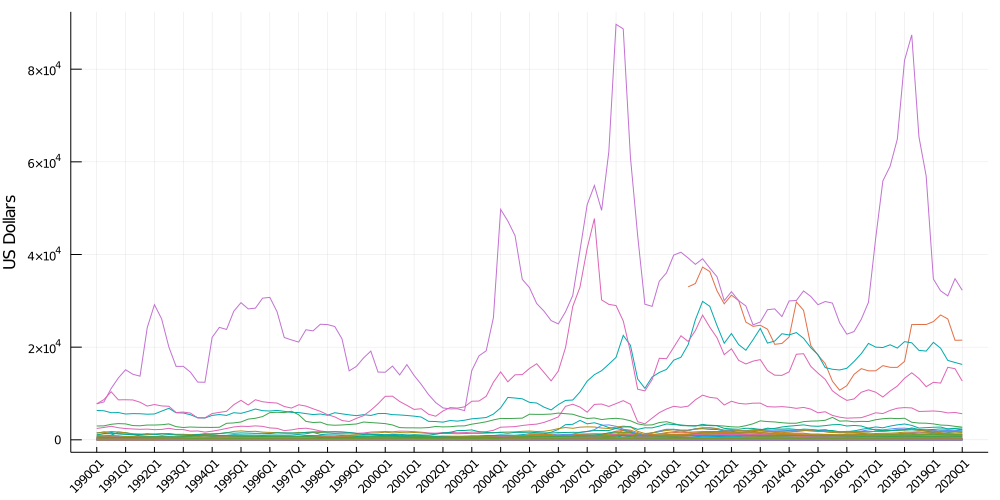

In [5]:
plot_series(df_comm,"US Dollars")

#### Index

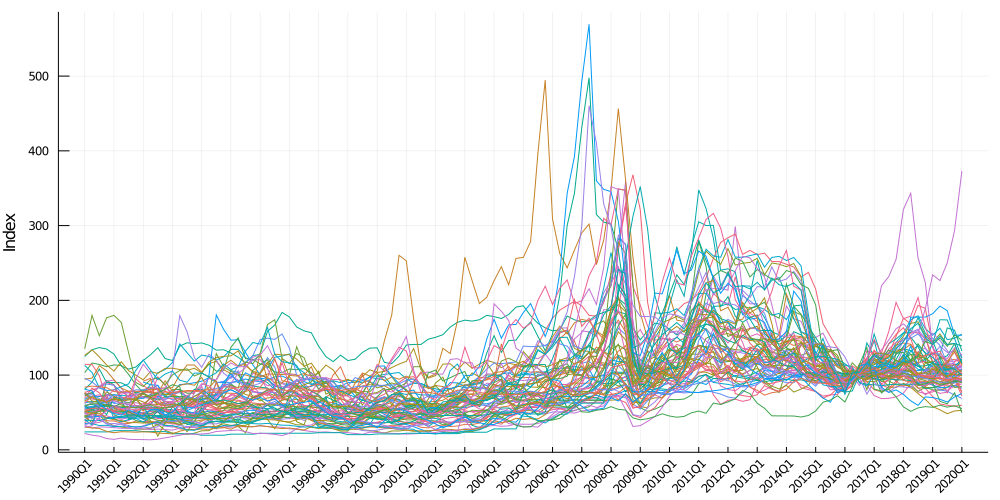

In [6]:
plot_series(df_comm,"Index")

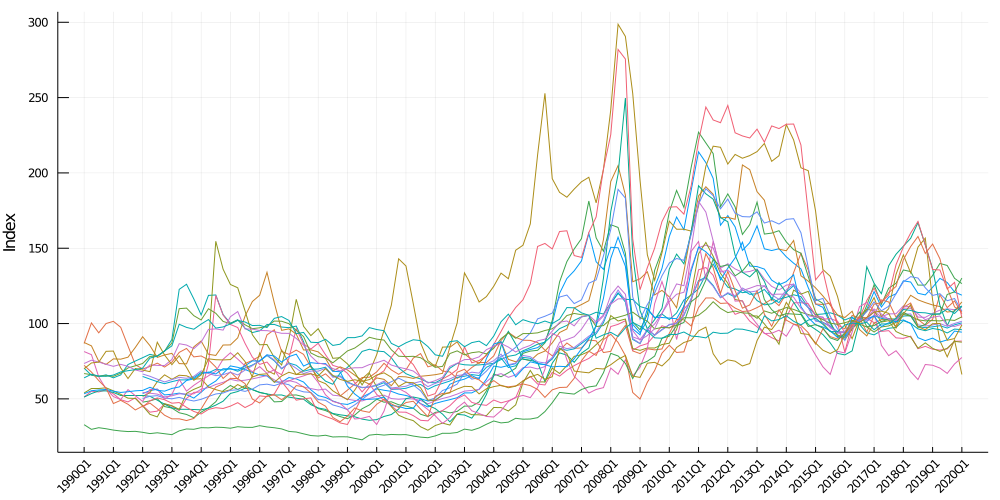

In [7]:
plot_series(df_group,"Index")

#### Percent Change over Previous Period

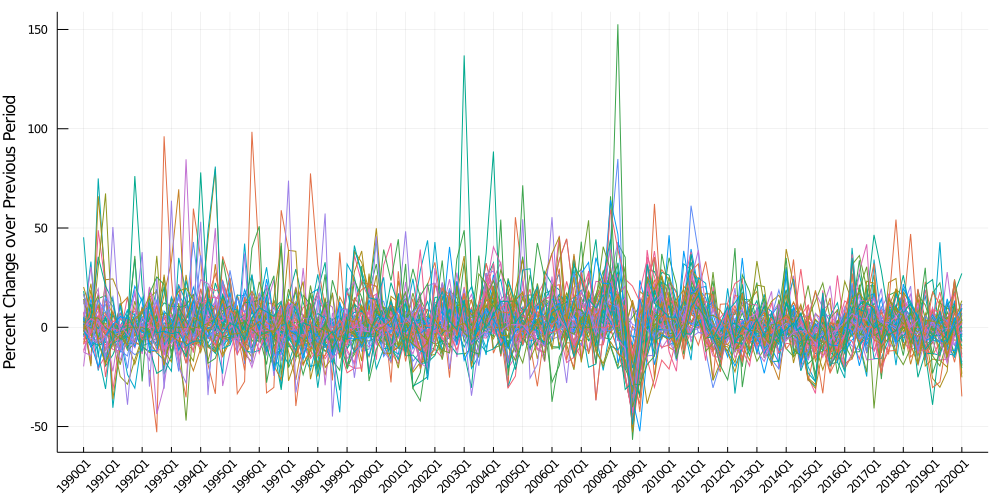

In [8]:
plot_series(df_comm,"Percent Change over Previous Period")

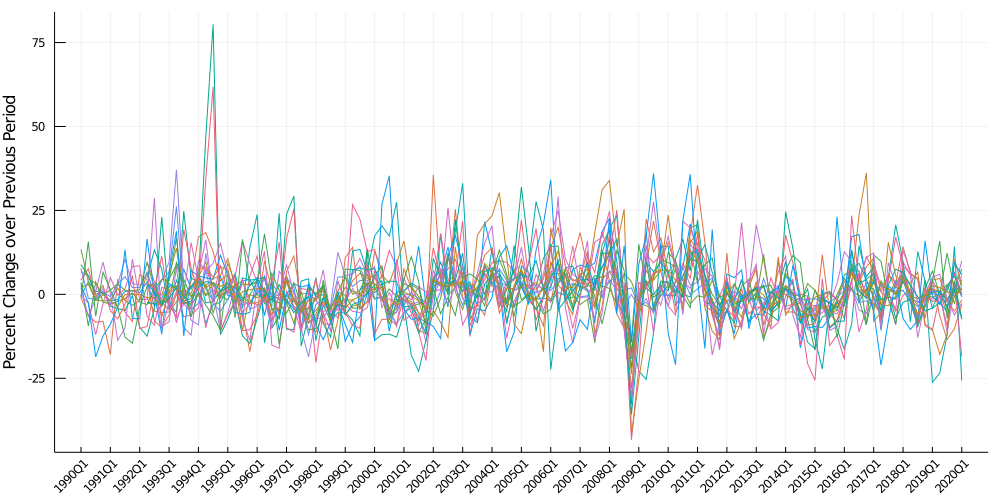

In [9]:
plot_series(df_group,"Percent Change over Previous Period")

#### Percent Change over Corresponding Period Previous Year

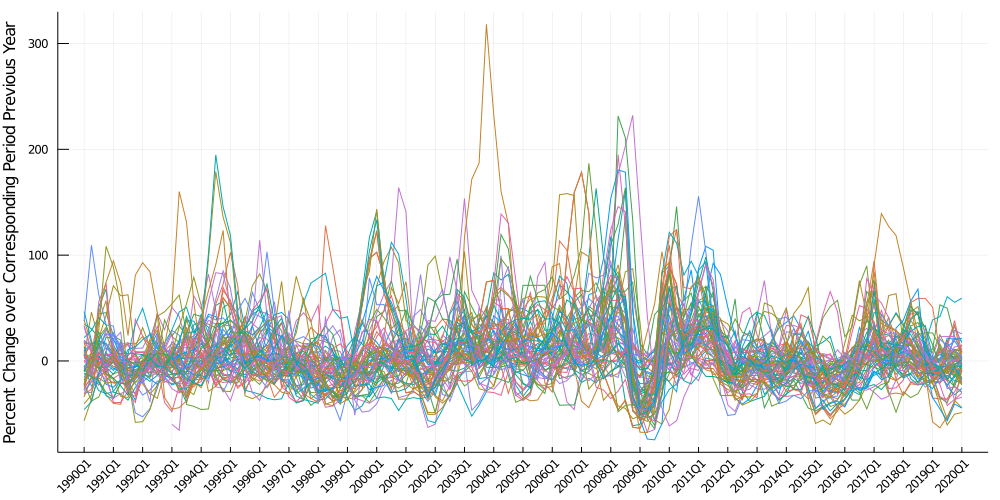

In [10]:
plot_series(df_comm,"Percent Change over Corresponding Period Previous Year")

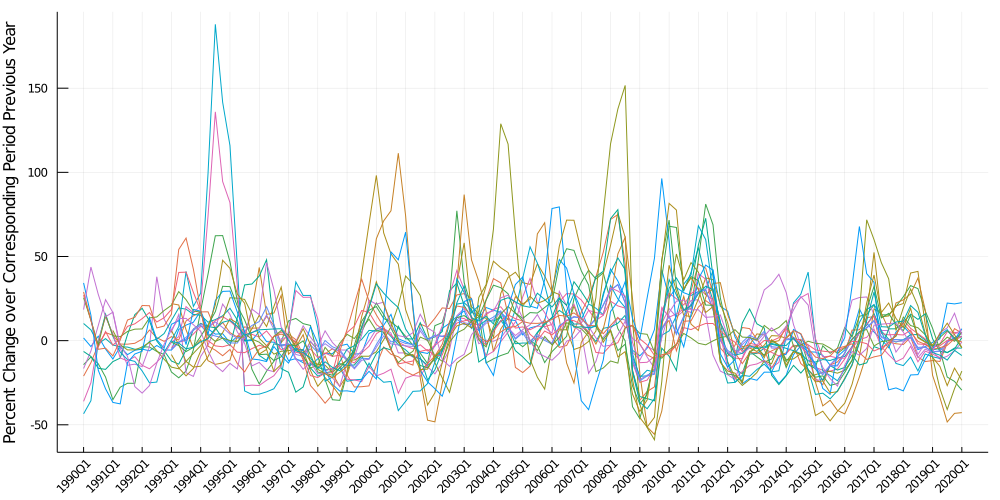

In [11]:
plot_series(df_group,"Percent Change over Corresponding Period Previous Year")

### AC2D Analysis

In [5]:
# List all indices
unique(df_group[:,Symbol("Commodity Name")])

22-element Array{String,1}:
 "Precious Metals Price Index"
 "Vegetable oil index "
 "Wool index "
 "Seafood index "
 "Energy index "
 "Agr. Raw Material Index "
 "Non-Fuel index "
 "Natural gas index "
 "Cereal  index"
 "Coal index "
 "Coffee index "
 "Food and beverage index"
 "Food index "
 "Hardwood index "
 "Industrial Materials index "
 "Meat Index "
 "Metal index "
 "Timber index "
 "Beverages index "
 "Softwood index "
 "Sugar index "
 "All index "

In [6]:
# Select indices
# ["Precious Metals Price Index","Vegetable oil index ","Wool index ","Seafood index ","Energy index ",
#  "Agr. Raw Material Index ","Non-Fuel index ","Natural gas index ","Cereal  index","Coal index ",
#  "Coffee index ","Food and beverage index","Food index ","Hardwood index ","Industrial Materials index ",
#  "Meat Index ","Metal index ","Timber index ","Beverages index ","Softwood index ","Sugar index ","All index "]

comm_names = ["Precious Metals Price Index","Vegetable oil index ","Wool index ","Seafood index ","Energy index ",
 "Agr. Raw Material Index ","Non-Fuel index ","Natural gas index ","Cereal  index","Coal index ",
 "Food index ","Hardwood index ","Industrial Materials index ","Meat Index ","Metal index ",
 "Beverages index ","Softwood index ","Sugar index "]

18-element Array{String,1}:
 "Precious Metals Price Index"
 "Vegetable oil index "
 "Wool index "
 "Seafood index "
 "Energy index "
 "Agr. Raw Material Index "
 "Non-Fuel index "
 "Natural gas index "
 "Cereal  index"
 "Coal index "
 "Food index "
 "Hardwood index "
 "Industrial Materials index "
 "Meat Index "
 "Metal index "
 "Beverages index "
 "Softwood index "
 "Sugar index "

In [109]:
# Specify dataset 
function get_data(df,units)
    df = df[df[:,Symbol("Unit Name")] .== units,:]
    all_names = df[:,Symbol("Commodity Name")]
    all_times = names(df)[8:ncol(df)]
    x = convert(Matrix,df[:,8:ncol(df)])
    return x,all_names,all_times
end

# Remove some commodity indices
bool = [in(i,comm_names) for i in df_group[:,Symbol("Commodity Name")]]
df_group_sub = df_group[bool,:]

# Get data
dat,all_names,all_times = get_data(df_group_sub,"Index")
print("----- Original Data -----\n")
print(string("missing count (columns): ", [sum(ismissing.(dat[i,:])) for i in 1:size(dat)[1]]'))
print(string("\nsize: ", size(dat),"\n"))

# Subset data to get rid of missing values
row_dat,col_dat = size(dat)
x = identity.(dat[:,col_dat-112:col_dat])

#legendlabel=reshape(all_names,(1,size(x)[2]))
timelabel=map(string,all_times)[col_dat-112:col_dat]

print("\n----- Subset Data -----\n")
print(string("missing count (columns): ", [sum(ismissing.(x[i,:])) for i in 1:size(x)[1]]'))
print(string("\nsize: ", size(x)))

----- Original Data -----
missing count (columns): [8 0 8 8 8 0 0 0 0 8 8 0 0 0 0 0 0 0]
size: (18, 121)

----- Subset Data -----
missing count (columns): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
size: (18, 113)

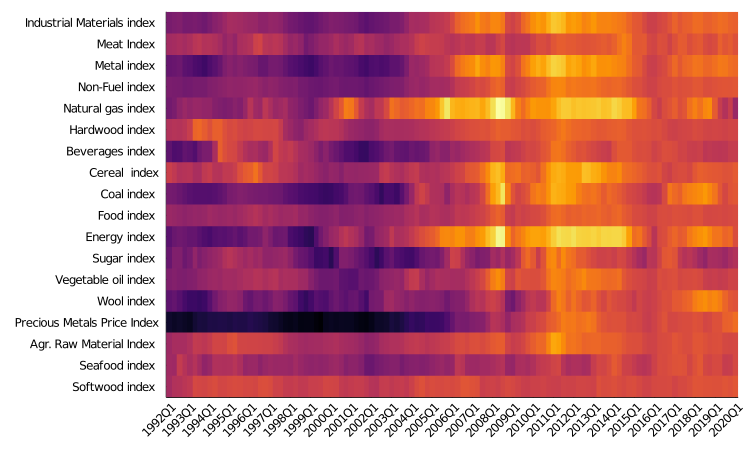

In [110]:
H = wavelet(WT.db2)
L_row = 2
L_col = 2
Q = qfilter(H)
P = pfilter(H)

ac = ac2d(x,L_row,L_col,P,Q)

function plot_heatmap(x)
   heatmap(log.(abs.(x)),
            yflip=true,
            colorbar_entry=false,
            #aspect_ratio=:equal,
            showaxis=false,
            size=(600,400))
end

function plot_heatmap_label(x,yticks_lab)
   heatmap(log.(abs.(x)),
            yflip=true,
            colorbar_entry=false,
            #aspect_ratio=:equal,
            #showaxis=false,
            size=(750,450),
            xrotation=45,
            xticks=(1:4:size(x)[2],timelabel[1:4:size(x)[2]]),
            yticks = (1:1:size(x)[1], yticks_lab))
end

# Heatmap of original data
plot_heatmap_label(x,all_names)

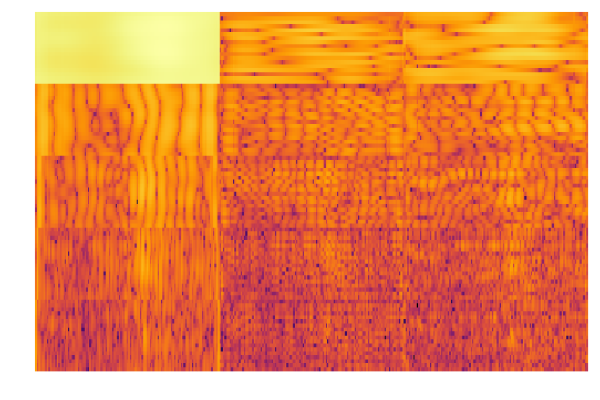

In [111]:
# Grid of all scales
row_dim,col_dim,row_scale,col_scale=size(ac)
tmp=[reduce(vcat, [ac[:,:,j,i] for j in 1:row_scale]) for i in 1:col_scale]
x_reshape=reduce(hcat, tmp)
plot_heatmap(x_reshape)

### Normalization

##### Unit Length

In [214]:
function normalize_unit(x,axis)
    if axis == 2 # normalize rows to unit length
        v = [1/norm(x[i, :]) for i in 1:size(x)[1]]
        x_normalize_unit = v .* x
    elseif axis == 1 # normalize columns to unit length
        v = [1/norm(x[:, i]) for i in 1:size(x)[2]]
        x_normalize_unit = transpose(v .* x')
    end
    return x_normalize_unit
end

x_normalize_unit_row = normalize_unit(x,2)
x_normalize_unit_col = normalize_unit(x,1)
x_normalize_unit = x_normalize_unit_row
sum([norm(x_normalize_unit[i, :]) for i in 1:size(x)[1]]) # check
#sum([norm(x_normalize_unit[:, i]) for i in 1:size(x)[2]]) # check

18.0

##### Loess

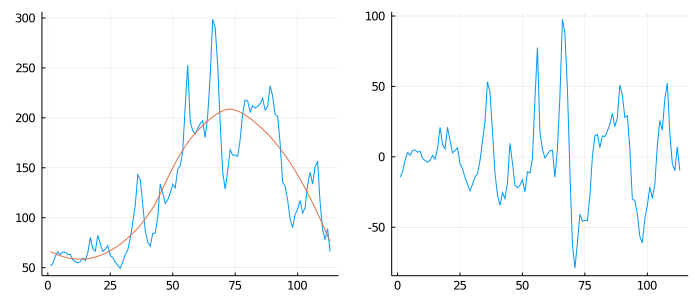

In [116]:
# Example for one vector
xs = collect(1:size(x)[2])
ys = x[5,:]
model = loess(xs, ys)

us = range(extrema(xs)...; step = 0.1)
vs = predict(model, us)

p1 = plot(xs,ys,legend=:none)
plot!(us,vs)

p2 = plot(xs,ys - vs[1:10:end],legend=:none)

plot(p1, p2,layout = (1, 2),size=(700,300))

In [134]:
function loess_fitted_1d(x,i,axis)
    """
    Input:
        x -- data matrix
        i -- index of row or column to normalize
        axis -- "2" to normalize rows, "1" to normalize columns
    Output:
        loess curve for the specified index
    """
    if axis == 2 # normalize rows to unit length
        xs = collect(1:size(x)[2])
        ys = x[i,:]
        model = loess(xs, ys)
    elseif axis == 1 # normalize columns to unit length
        xs = collect(1:size(x)[1])
        ys = x[:,i]
        model = loess(xs, ys)
    end
    
    us = range(extrema(xs)...; step = 0.1)
    vs = predict(model, us)[1:10:end]
    return vs
end

function loess_fitted(x,axis)
    """
    Input:
        x -- data matrix
        axis -- "2" to normalize rows, "1" to normalize columns
    Output:
        matrix of fitted loess curves
    """
    if axis == 2 # normalize rows to unit length
        x_loess = hcat([loess_fitted_1d(x,i,2) for i in 1:size(x)[1]]...)'
    elseif axis == 1 # normalize columns to unit length
        x_loess = hcat([loess_fitted_1d(x,i,1) for i in 1:size(x)[2]]...)
    end
    
    return x_loess
end

# function normalize_loess(x,fitted)
#     """
#     Input:
#         x -- data matrix
#         fitted -- matrix of fitted loess curves
#     Output:
#         data matrix normalized by subtracting loess curve from its respective vector
#     """
#     return x - fitted
# end

# Normalize using loess
loess_fit_row = loess_fitted(x,2)
loess_fit_col = loess_fitted(x,1)

x_normalize_loess_row = x - loess_fit_row
x_normalize_loess_col = x - loess_fit_col

t = loess_fitted(x_normalize_loess_row,1)
x_normalize_loess = x_normalize_loess_row - t

18×113 Array{Float64,2}:
  -4.22055     -4.27087    -4.45931    -2.71934    …    0.769395    2.90252
   1.53999      1.27298     1.42637     1.67487        -5.77659   -10.3481
   4.17156      4.31031     4.30764     0.496491        8.29083    10.4102
   7.69209      6.60041     4.23436     1.58205         0.496067    6.9877
  -0.330818     3.28527    10.1799     13.3415         -3.86366   -19.306
 -16.274      -12.0432    -12.4016    -11.0314     …   -1.22429     0.0717812
  -0.0665974   -3.90789    -3.28113    -3.06208         0.973657    1.11041
   6.83187      3.92061    -0.901478   -0.62291        12.67       19.2325
   1.79062      3.79394     4.61372     2.82112       -16.413     -15.4948
   3.19745      0.672836    0.148414    0.0531833      -4.9054     -1.84843
  -1.67482      0.342093    3.70418     6.24084    …   14.4612     -1.56812
  -7.8552      -3.90616    -2.8294     -6.45906         0.550144   10.0248
  -1.28103     -3.05308    -4.22306    -2.09055         4.99737     7

##### Remove linear trend

In [292]:
function linear_fitted_1d(x,i,axis)
    if axis == 2 # normalize rows to unit length
        xs = collect(1:size(x)[2])
        p1 = [xs[1], x[i,:][1]]
        pn = [xs[size(x)[2]], x[i,:][size(x)[2]]]
        m = (pn[2]-p1[2])/(pn[1]-p1[1])
        b = p1[2] - m*p1[1]
        line = m.*xs .+ b
    elseif axis == 1 # normalize columns to unit length
        xs = collect(1:size(x)[1])
        p1 = [xs[1], x[:,i][1]]
        pn = [xs[size(x)[1]], x[:,i][size(x)[1]]]
        m = (pn[2]-p1[2])/(pn[1]-p1[1])
        b = p1[2] - m*p1[1]
        line = m.*xs .+ b
    end
    return line
end

function linear_fitted(x,axis)
    """
    Input:
        x -- data matrix
        axis -- "2" to normalize rows, "1" to normalize columns
    Output:
        matrix of fitted lines
    """
    if axis == 2 # normalize rows to unit length
        x_linear = hcat([linear_fitted_1d(x,i,2) for i in 1:size(x)[1]]...)'
    elseif axis == 1 # normalize columns to unit length
        x_linear = hcat([linear_fitted_1d(x,i,1) for i in 1:size(x)[2]]...)
    end
    
    return x_linear
end

linear_fitted (generic function with 1 method)

##### Standardization

In [206]:
standardize_row = standardize(ZScoreTransform, x, dims=2)
standardize_col = standardize(ZScoreTransform, x, dims=1)

standardize(ZScoreTransform, standardize_row, dims=1)
standardize(ZScoreTransform, standardize_col, dims=2)

18×113 Array{Float64,2}:
  0.137734     0.121341    0.0187367   …   0.289753    0.0291095  -0.0893435
  0.165903     0.26519     0.299976        0.953353    1.48176     0.510612
  0.248718     0.211636    0.0975596       0.418558    0.153199   -0.0161731
  0.145179    -0.0112097  -0.159571        0.477707    0.474555    0.427897
 -0.298829    -0.502613   -0.282332       -1.9929     -2.09788    -2.24465
  0.13732      0.308923   -0.00334933  …  -0.925269   -0.908881   -0.802012
 -0.422411    -1.20248    -0.977559       -0.467285   -0.248122   -0.234828
  1.12309      1.02867     0.281396       -0.727247   -0.887537   -0.522265
  0.539522     0.55928     0.207825       -0.412239   -0.157048   -0.0838271
  0.313143     0.0930529  -0.205887        0.0993294   0.212749    0.220393
 -0.0075093   -0.0344125  -0.0890713   …  -0.620985   -0.676208   -1.08186
  0.327392     1.00529     0.661313       -1.04314    -0.878637   -0.52059
 -0.00508588  -0.0111612  -0.248377       -0.629655   -0.443974

##### Normalization function

In [ ]:
function normalize(x,method_row,method_col)
    if method_row = "unit"
    elseif method_row = "loess"
    elseif method_row = "linear"
    end
    
    if method_col = "unit"
    elseif method_col = "loess"
    elseif method_col = "linear"
    end
end

methods = ["unit","loess","linear"]

### Clustering & AC2D Decomposition

In [218]:
function cluster_comm(x_normalize)
    # Compute pairwise distances and cluster
    dist=Euclidean()
    D = pairwise(dist,x_normalize,dims=1)
    result = hclust(D, linkage=:ward, branchorder=:optimal)
    tree_order = result.order

    # Reorder data matrix based on tree order
    x_clustered = x[tree_order,:]

    # Reorder commodities to match tree order
    comm_clustered = all_names[tree_order]

    # Redo ac2d on clustered matrix
    ac_clustered = ac2d(x_clustered,L_row,L_col,P,Q)
    
    return [x_clustered, comm_clustered, ac_clustered]
end

cluster_comm (generic function with 1 method)

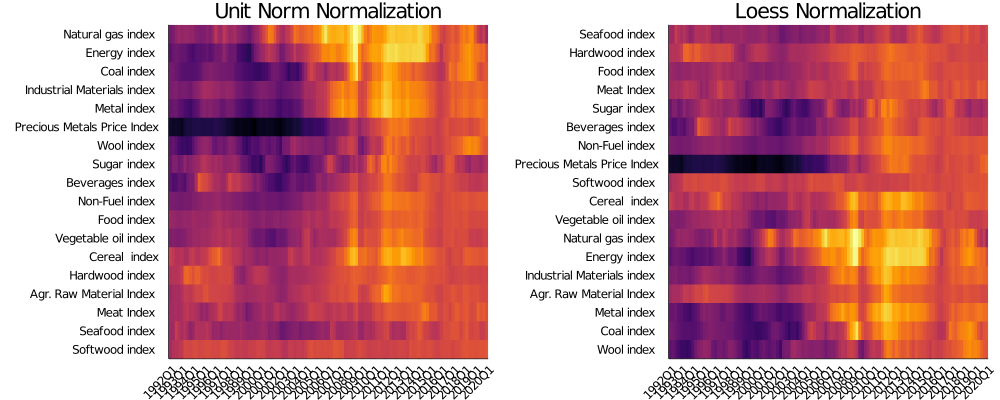

In [221]:
x_clustered_unit, comm_clustered_unit, ac_clustered_unit = cluster_comm(x_normalize_unit)
x_clustered_loess, comm_clustered_loess, ac_clustered_loess = cluster_comm(x_normalize_loess)

p1 = plot_heatmap_label(x_clustered_unit,comm_clustered_unit)
title!("Unit Norm Normalization")

p2 = plot_heatmap_label(x_clustered_loess,comm_clustered_loess)
title!("Loess Normalization")
plot!(yflip=false)

plot(p1, p2,layout = (1, 2))
plot!(size=(1000,400))

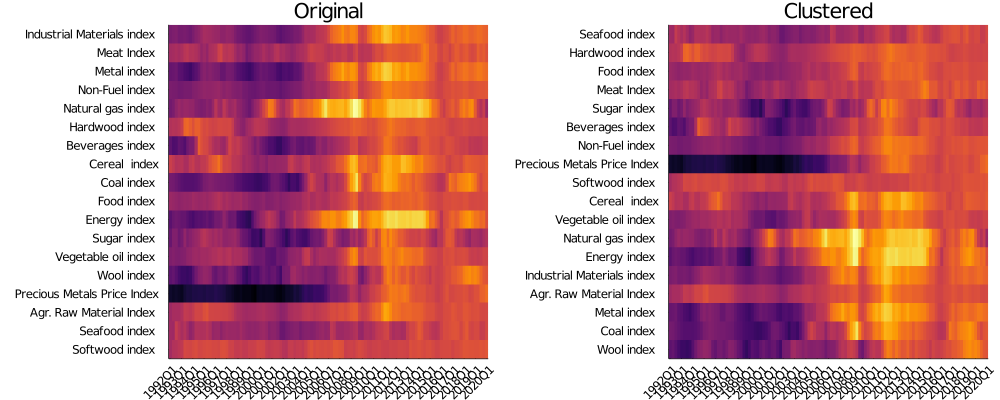

In [222]:
p1 = plot_heatmap_label(x,all_names)
title!("Original")

p2 = plot_heatmap_label(x_clustered_loess,comm_clustered_loess)
plot!(yflip=false)
title!("Clustered")

plot(p1, p2,layout = (1, 2))
plot!(size=(1000,400))

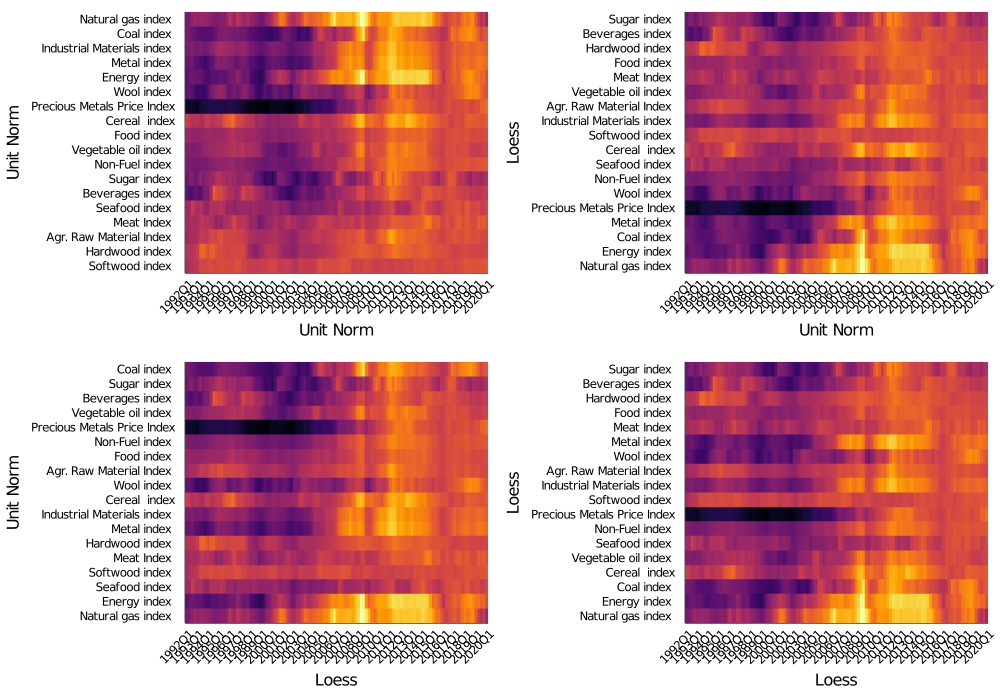

In [278]:
# Row: unit
# Column: unit
x_normalize_unit_row = normalize_unit(x,2)
x_normalize = normalize_unit(x_normalize_unit_row,1)
x_clustered, comm_clustered, ac_clustered = cluster_comm(x_normalize)
p1 = plot_heatmap_label(x_clustered,comm_clustered)
xlabel!("Unit Norm")
ylabel!("Unit Norm")

# Row: unit
# Column: loess
x_normalize_unit_row = normalize_unit(x,2)
loess_fit_col = loess_fitted(x_normalize_unit_row,1)
x_normalize = x_normalize_unit_row - loess_fit_col
x_clustered, comm_clustered, ac_clustered = cluster_comm(x_normalize)
p2 = plot_heatmap_label(x_clustered,comm_clustered)
xlabel!("Unit Norm")
ylabel!("Loess")

# Row: loess
# Column: unit
loess_fit_row = loess_fitted(x,2)
x_normalize_loess_row = x - loess_fit_row
x_normalize = normalize_unit(x_normalize_loess_row,1)
x_clustered, comm_clustered, ac_clustered = cluster_comm(x_normalize)
p3 = plot_heatmap_label(x_clustered,comm_clustered)
xlabel!("Loess")
ylabel!("Unit Norm")

# Row: loess
# Column: loess
loess_fit_row = loess_fitted(x,2)
x_normalize_loess_row = x - loess_fit_row
t = loess_fitted(x_normalize_loess_row,1)
x_normalize = x_normalize_loess_row - t
#x_normalize_loess = normalize_unit(x_normalize_loess, 2)
x_clustered, comm_clustered, ac_clustered = cluster_comm(x_normalize)
p4 = plot_heatmap_label(x_clustered,comm_clustered)
xlabel!("Loess")
ylabel!("Loess")

plot(p1, p2, p3, p4, layout = (2, 2))
plot!(size=(1000,700))

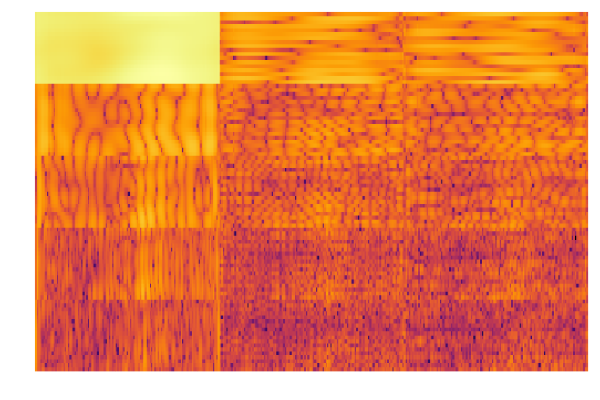

In [23]:
# Choose normalization method
x_clustered = x_clustered_loess
comm_clustered = comm_clustered_loess
ac_clustered = ac_clustered_loess

# Heatmap of accoef
plot_heatmap(ac_clustered[:,:,2,1])
plot_heatmap(ac_clustered[:,:,1,3])

# Grid of all scales
row_dim,col_dim,row_scale,col_scale=size(ac_clustered)
tmp=[reduce(vcat, [ac_clustered[:,:,j,i] for j in 1:row_scale]) for i in 1:col_scale]
x_reshape=reduce(hcat, tmp)
plot_heatmap(x_reshape)
plot!(size=(600,400))

### Thresholding

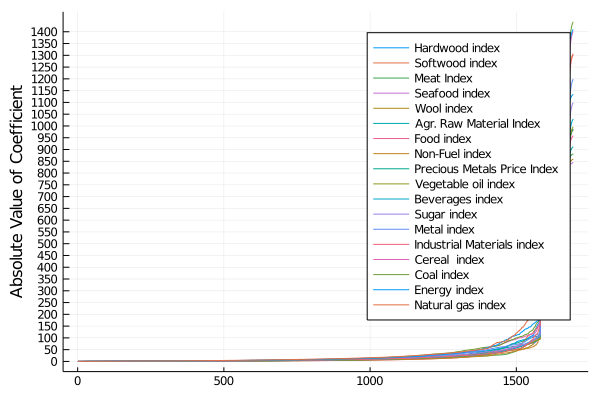

In [29]:
function accoef_single_feature(ac_clustered, feat_ind)
    tmp = []
    for i in 1:size(ac_clustered)[3]
        for j in 1:size(ac_clustered)[4]
            append!(tmp,ac_clustered[feat_ind,:,i,j])
        end
    end
    return sort(abs.(tmp))
end

# Matrix of sorted abs coefficients by time series (dimensions: #timepoints*row_scale*col_scale x #timeseries)
accoef_byfeat = hcat([accoef_single_feature(ac_clustered,i) for i in 1:size(ac_clustered)[1]]...)

#plotly()
gr()
plot(accoef_byfeat,
    yticks=0:50:maximum(accoef_byfeat),
    #label = reshape(comm_clustered, (1,length(comm_clustered))), legend=:topleft)
    label = reshape(comm_clustered, (1,length(comm_clustered))),
    size=(600,400))
ylabel!("Absolute Value of Coefficient")

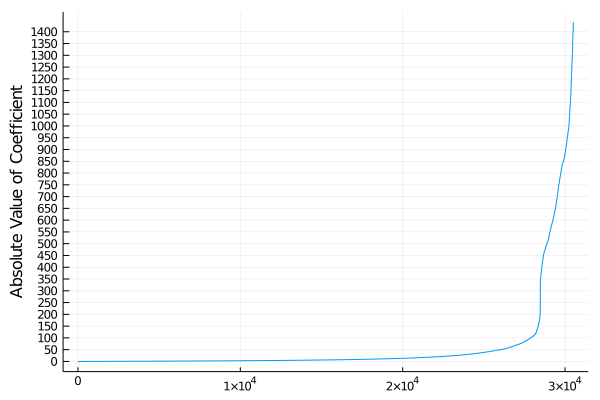

In [25]:
gr()
coef = sort(abs.(ac_clustered[:]))
plot(coef,legend=:none,yticks=0:50:maximum(coef))
ylabel!("Absolute Value of Coefficient")

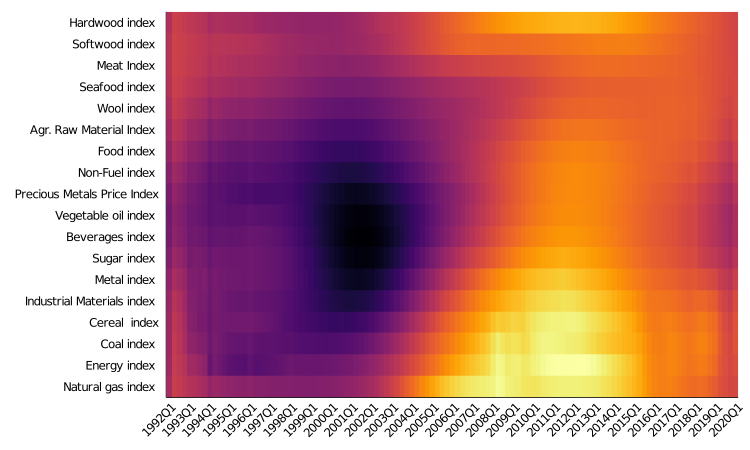

In [26]:
ac_thresh = acthreshold(ac_clustered, "soft", 100)
iac = iac2d(ac_thresh)
plot_heatmap_label(iac,comm_clustered)

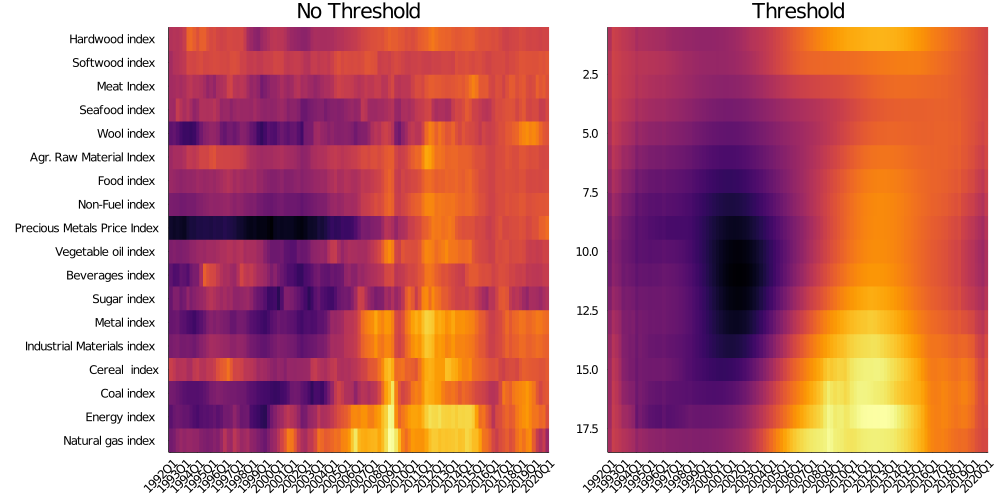

In [27]:
p1 = plot_heatmap_label(x_clustered,comm_clustered)
title!("No Threshold")

p2 = heatmap(log.(abs.(iac)),
   colorbar_entry=false,
   size=(800,500),
   xrotation=45,
   xticks=(1:4:size(x)[2],timelabel[1:4:size(x)[2]]),
   #yticks = (1:1:size(x)[1], comm_clustered),
   yflip=true)
title!("Threshold")

plot(p1, p2)
plot!(size=(1000,500))